In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

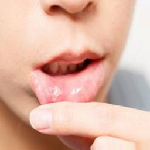

In [5]:
img = image.load_img("/kaggle/input/teeth/Training/CaS/a_100_0_1462.jpg", target_size=(150, 150))
img

In [6]:
cv2.imread("/kaggle/input/teeth/Training/CaS/a_100_0_1462.jpg").shape

(256, 256, 3)

In [8]:
train_dataset.class_indices

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}

In [9]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [9]:
import tensorflow as tf
import os
import logging

tf.get_logger().setLevel(logging.ERROR)

# Define improved augmentation functions for tf.data
def augment_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    scale_factor = tf.random.uniform([], 0.8, 1.0, dtype=tf.float32)
    new_size = tf.cast(tf.cast(150, tf.float32) * scale_factor, tf.int32)
    image = tf.image.resize(image, [new_size, new_size])
    image_shape = tf.shape(image)
    crop_height = tf.minimum(150, image_shape[1])
    crop_width = tf.minimum(150, image_shape[2])
    crop_size = tf.concat([image_shape[0:1], [crop_height, crop_width], image_shape[3:4]], axis=0)
    image = tf.image.random_crop(image, crop_size)
    paddings = [[0, 0], [0, 150 - crop_height], [0, 150 - crop_width], [0, 0]]
    image = tf.pad(image, paddings, mode='CONSTANT', constant_values=0.0)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# Load and prepare dataset with tf.data, preserving class_names
def load_dataset(data_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(150, 150),
        batch_size=32,
        label_mode='int',
        shuffle=True
    )
    class_names = dataset.class_names
    return dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE).repeat().prefetch(tf.data.AUTOTUNE), class_names

train_dataset, train_class_names = load_dataset('/kaggle/input/teeth/Training/')
validation_dataset, validation_class_names = load_dataset('/kaggle/input/teeth/Validation/')

print(f"Found {tf.data.experimental.cardinality(train_dataset).numpy() * 32} training images.")
print(f"Found {tf.data.experimental.cardinality(validation_dataset).numpy() * 32} validation images.")

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found -32 training images.
Found -32 validation images.


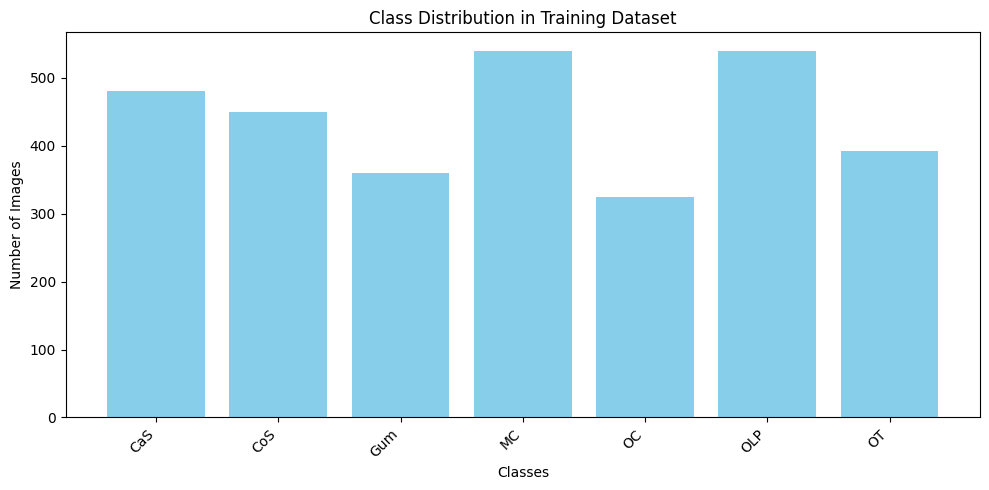

Debugging Augmentation Output:
Original Shape: (150, 150, 3)
Original Min: 0.0000, Max: 1.0000
Augmented Set 1 Min: 0.0000, Max: 1.0000
Augmented Set 2 Min: 0.0000, Max: 1.0000
Augmented Set 3 Min: 0.0000, Max: 1.0000


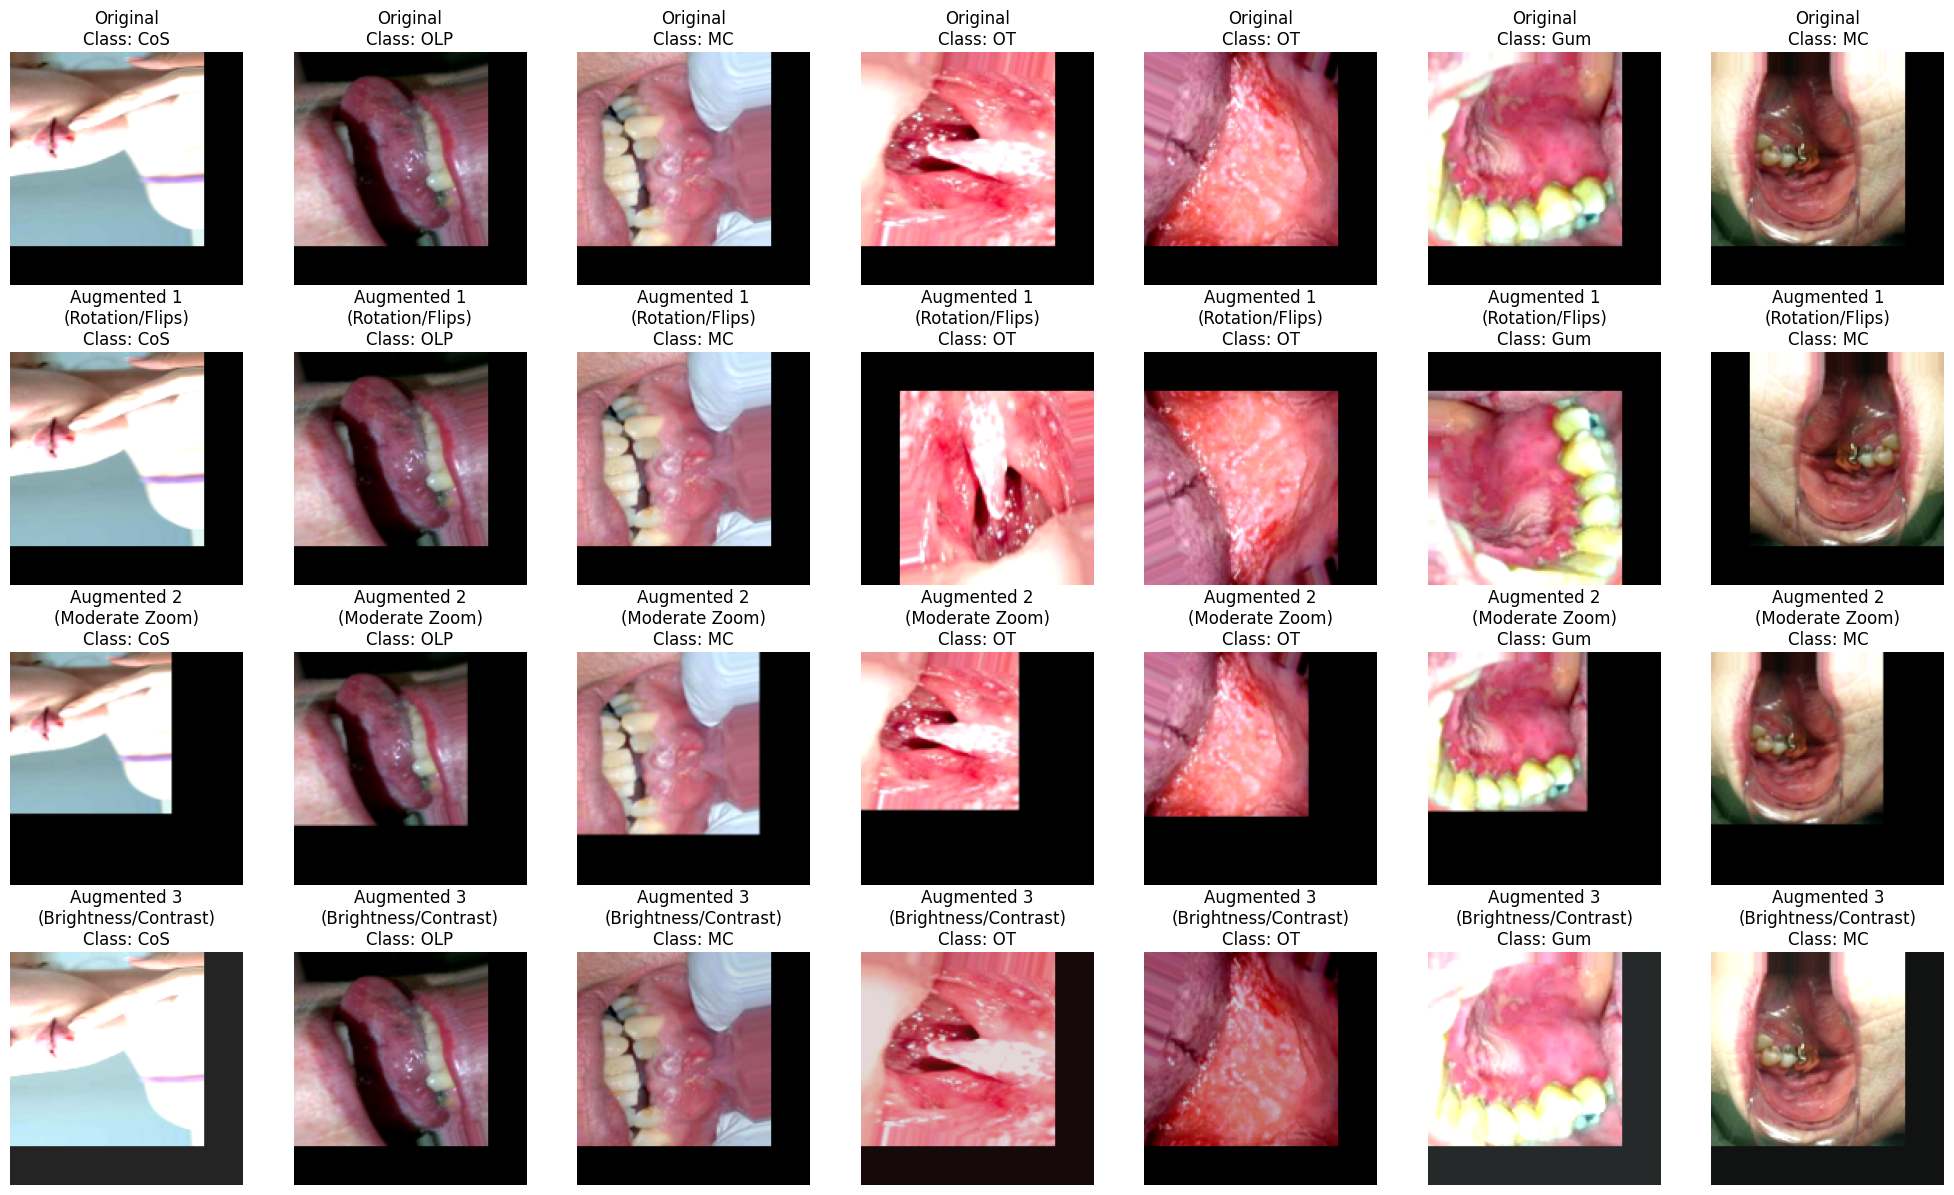

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_class_distribution(dataset, class_names):
    class_counts = np.zeros(len(class_names))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join('/kaggle/input/teeth/Training/', class_name)
        class_counts[i] = len(os.listdir(class_dir))
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts, color='skyblue')
    plt.title('Class Distribution in Training Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_augmentation_examples(dataset, class_names):
    for x_batch, y_batch in dataset.take(1):
        original_images = x_batch.numpy()
        labels = y_batch.numpy()
        break
    
    def apply_augmentation_set1(images):
        aug_images = []
        for img in images:
            img = tf.convert_to_tensor(img)
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_flip_up_down(img)
            img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
            img = tf.clip_by_value(img, 0.0, 1.0)
            aug_images.append(img)
        return tf.stack(aug_images)
    
    def apply_augmentation_set2(images):
        aug_images = []
        for img in images:
            img = tf.convert_to_tensor(img)
            scale_factor = tf.random.uniform([], 0.8, 1.0, dtype=tf.float32)
            new_size = tf.cast(tf.cast(150, tf.float32) * scale_factor, tf.int32)
            img = tf.image.resize(img, [new_size, new_size])
            img_shape = tf.shape(img)
            crop_height = tf.minimum(150, img_shape[0])
            crop_width = tf.minimum(150, img_shape[1])
            crop_size = [crop_height, crop_width, img_shape[2]]
            img = tf.image.random_crop(img, crop_size)
            paddings = [[0, 150 - crop_height], [0, 150 - crop_width], [0, 0]]
            img = tf.pad(img, paddings, mode='CONSTANT', constant_values=0.0)
            img = tf.clip_by_value(img, 0.0, 1.0)
            aug_images.append(img)
        return tf.stack(aug_images)
    
    def apply_augmentation_set3(images):
        aug_images = []
        for img in images:
            img = tf.convert_to_tensor(img)
            img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_contrast(img, lower=0.7, upper=1.3)
            img = tf.clip_by_value(img, 0.0, 1.0)
            aug_images.append(img)
        return tf.stack(aug_images)

    aug_images_1 = apply_augmentation_set1(original_images)
    aug_images_2 = apply_augmentation_set2(original_images)
    aug_images_3 = apply_augmentation_set3(original_images)
    
    print("Debugging Augmentation Output:")
    print(f"Original Shape: {original_images.shape[1:]}")
    print(f"Original Min: {np.min(original_images):.4f}, Max: {np.max(original_images):.4f}")
    print(f"Augmented Set 1 Min: {np.min(aug_images_1):.4f}, Max: {np.max(aug_images_1):.4f}")
    print(f"Augmented Set 2 Min: {np.min(aug_images_2):.4f}, Max: {np.max(aug_images_2):.4f}")
    print(f"Augmented Set 3 Min: {np.min(aug_images_3):.4f}, Max: {np.max(aug_images_3):.4f}")
    
    plt.figure(figsize=(20, 12))
    for i in range(min(7, len(original_images))):
        plt.subplot(4, 7, i + 1)
        plt.imshow(original_images[i])
        plt.title(f'Original\nClass: {class_names[int(labels[i])]}')
        plt.axis('off')
        
        plt.subplot(4, 7, i + 8)
        plt.imshow(aug_images_1[i])
        plt.title(f'Augmented 1\n(Rotation/Flips)\nClass: {class_names[int(labels[i])]}')
        plt.axis('off')
        
        plt.subplot(4, 7, i + 15)
        plt.imshow(aug_images_2[i])
        plt.title(f'Augmented 2\n(Moderate Zoom)\nClass: {class_names[int(labels[i])]}')
        plt.axis('off')
        
        plt.subplot(4, 7, i + 22)
        plt.imshow(aug_images_3[i])
        plt.title(f'Augmented 3\n(Brightness/Contrast)\nClass: {class_names[int(labels[i])]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, train_class_names)
plot_augmentation_examples(train_dataset, train_class_names)

Num GPUs Available:  1
Starting training on GPU...
Starting first step to verify data...
First Batch Shape: (32, 150, 150, 3), Min: 0.0000, Max: 0.8355
Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.2668 - loss: 2.3903 - val_accuracy: 0.1641 - val_loss: 5.1874 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.3567 - loss: 2.1010 - val_accuracy: 0.1865 - val_loss: 4.6938 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.3765 - loss: 1.9780 - val_accuracy: 0.1592 - val_loss: 4.2988 - learning_rate: 0.0010
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.4038 - loss: 1.8519 - val_accuracy: 0.1914 - val_loss: 3.1123 - learning_rate: 0.0010
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.4529 - loss: 1.7122 - val_accuracy: 0.1885 - val_loss: 3.7752 - learning_rate: 0.0010
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4634 - loss: 1.6240 - val_

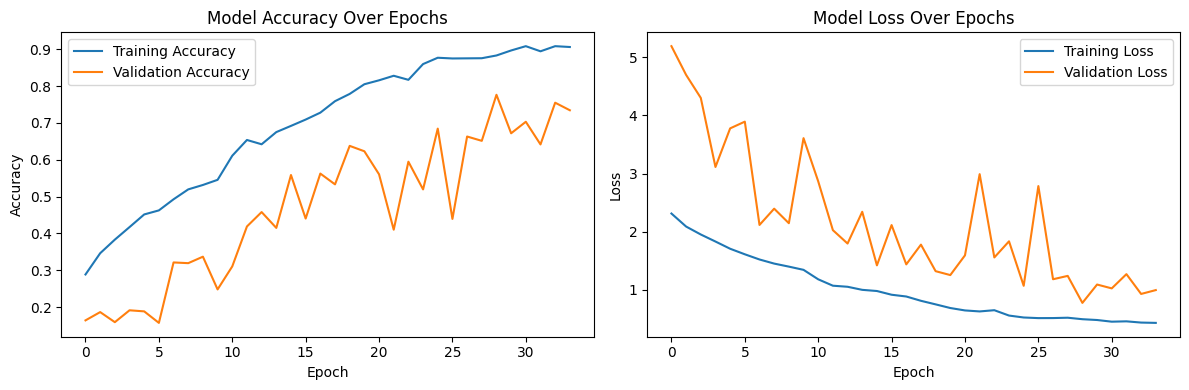

Model saved as teeth_classification_model.pkl with class names.


In [17]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

# Confirm GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Starting training on GPU...")

# Disable mixed precision to avoid Cast layer issues
# set_global_policy('mixed_float16')  # Commented out

# Use Input layer to define input shape
inputs = Input(shape=(150, 150, 3))

# Enhanced model architecture
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(2, 2)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
x = Dropout(0.2)(x)
outputs = Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile with optimized hyperparameters
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Compute class weights
y_train = np.concatenate([y for x, y in train_dataset.take(97)], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('teeth_classification_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Record start time
start_time = time.time()

# Train with verbose output and debugging
print("Starting first step to verify data...")
for x_batch, y_batch in train_dataset.take(1):
    print(f"First Batch Shape: {x_batch.shape}, Min: {tf.reduce_min(x_batch):.4f}, Max: {tf.reduce_max(x_batch):.4f}")
    break

history = model.fit(
    train_dataset,
    steps_per_epoch=97,
    epochs=50,
    validation_data=validation_dataset,
    validation_steps=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

# Calculate and print runtime
end_time = time.time()
runtime = end_time - start_time
print(f"Training completed in {runtime / 60:.2f} minutes.")

# Visualize training performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save the model using pickle
with open('teeth_classification_model.pkl', 'wb') as f:
    pickle.dump({'model': model, 'class_names': train_class_names}, f)
print("Model saved as teeth_classification_model.pkl with class names.")

In [18]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_9 (Cast)                        │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 37, 37, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 37, 37, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,029,147 (26.81 MB)

 Trainable params: 2,342,407 (8.94 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 4,684,820 (17.87 MB)